In [1]:
!pip -q install wfdb==4.1.2 scipy==1.11.4

import os
from pathlib import Path
import numpy as np
from scipy.signal import butter, filtfilt, iirnotch, resample_poly
import wfdb
from wfdb import io
import tensorflow as tf


In [2]:
DATA_ROOT = Path("/content/physionet_afdb")   # folder you control
LOCAL_DB  = DATA_ROOT / "afdb"

def ensure_afdb_download():
    DATA_ROOT.mkdir(parents=True, exist_ok=True)
    if not LOCAL_DB.exists() or not any(LOCAL_DB.glob("*.hea")):
        print("→ Downloading AFDB to", DATA_ROOT)
        io.dl_database(
            "afdb",
            dl_dir=str(DATA_ROOT),          # will create /content/physionet_afdb/afdb
            keep_subdirs=True,
            overwrite=False
        )
    # Sanity prints
    heads = sorted([p.name for p in LOCAL_DB.glob("*.hea")])[:5]
    print(f"Local AFDB present: {LOCAL_DB.exists()} | headers found: {len(list(LOCAL_DB.glob('*.hea')))}")
    print("Sample headers:", heads)

# List of all record IDs from PhysioNet (includes 2 annotation-only records)
ALL_RECORDS = wfdb.get_record_list("afdb")
# Exclude annotation-only records (no ECG signal files)
SIGNAL_RECORDS = [r for r in ALL_RECORDS if r not in ("00735", "03665")]

ensure_afdb_download()
print("Total records:", len(ALL_RECORDS), "| usable signal records:", len(SIGNAL_RECORDS))


→ Downloading AFDB to /content/physionet_afdb
Generating record list for: 00735
Generating record list for: 03665
Generating record list for: 04015
Generating record list for: 04043
Generating record list for: 04048
Generating record list for: 04126
Generating record list for: 04746
Generating record list for: 04908
Generating record list for: 04936
Generating record list for: 05091
Generating record list for: 05121
Generating record list for: 05261
Generating record list for: 06426
Generating record list for: 06453
Generating record list for: 06995
Generating record list for: 07162
Generating record list for: 07859
Generating record list for: 07879
Generating record list for: 07910
Generating record list for: 08215
Generating record list for: 08219
Generating record list for: 08378
Generating record list for: 08405
Generating record list for: 08434
Generating record list for: 08455
Generating list of all files for: 00735
Generating list of all files for: 03665
Generating list of all f

In [3]:
# ==================== FULL REPLACEMENT BLOCK (AF_LABEL_RULE="any") ====================
# Minimal imports (safe to duplicate)
import numpy as np
from pathlib import Path
import wfdb
from scipy.signal import butter, filtfilt, iirnotch, resample_poly

# If not defined earlier, set the local DB path used when available
DATA_ROOT = Path("/content/physionet_afdb")
LOCAL_DB  = DATA_ROOT / "afdb"

# -------------------- Config --------------------
TARGET_FS   = 200         # Resample target Hz (set None to keep native 250 Hz)
WIN_SEC     = 10.0        # window length (s)
STEP_SEC    = 2.0         # stride (s); use WIN_SEC for non-overlap
BANDPASS    = (0.5, 40.0) # ECG band (Hz)
USE_NOTCH   = True
NOTCH_FREQ  = 50.0        # 50 (EU/India) or 60 (US)
Q_FACTOR    = 30.0
LEAD_INDEX  = 0           # single-lead use

# Labeling knobs
POSITIVE_RHYTHMS = {"AFIB", "AFL"}
AF_LABEL_RULE    = "any"

# ------------------ DSP helpers -----------------
def butter_bandpass_filter(x, fs, low, high, order=4):
    ny = 0.5 * fs
    b, a = butter(order, [low/ny, high/ny], btype="band")
    return filtfilt(b, a, x)

def apply_notch(x, fs, f0=50.0, q=30.0):
    b, a = iirnotch(w0=f0/(fs/2.0), Q=q)
    return filtfilt(b, a, x)

def resample_to(x, fs_src, fs_dst):
    if fs_dst is None or abs(fs_src - fs_dst) < 1e-9:
        return x, fs_src
    from math import gcd
    g = gcd(int(fs_src), int(fs_dst))
    up, down = int(fs_dst // g), int(fs_src // g)
    y = resample_poly(x, up, down)
    return y, fs_dst

# -------- Rhythm parsing (handles "(AFIB", "(N", etc.) --------
def rhythm_mask_from_ann(rec_id, n_samples):
    """Return boolean mask True where rhythm is in POSITIVE_RHYTHMS."""
    # Try local annotation first, then remote
    try:
        ann = wfdb.rdann(str(LOCAL_DB / rec_id), "atr")
    except Exception:
        ann = wfdb.rdann(rec_id, "atr", pn_dir="afdb")

    mask = np.zeros(n_samples, dtype=bool)
    changes = []
    for s, note in zip(ann.sample, ann.aux_note):
        if note:
            lab = str(note).strip().upper().strip("()")  # e.g., "(AFIB" -> "AFIB"
            changes.append((int(s), lab))
    changes.sort(key=lambda t: t[0])
    changes.append((int(n_samples), "END"))

    for (s0, lab0), (s1, _) in zip(changes[:-1], changes[1:]):
        if any(pos in lab0 for pos in POSITIVE_RHYTHMS):
            s0 = max(s0, 0); s1 = min(s1, n_samples)
            if s1 > s0:
                mask[s0:s1] = True
    return mask

# -------------------- Windowing --------------------
def make_windows(x, af_mask, fs, win_sec, step_sec):
    win = int(round(win_sec * fs))
    step = int(round(step_sec * fs))
    X, y = [], []
    for start in range(0, len(x) - win + 1, step):
        end = start + win
        seg = x[start:end]
        # "any" rule: label = 1 if ANY AF present in the window
        label = 1 if af_mask[start:end].any() else 0
        # Per-window z-score normalization
        seg = (seg - seg.mean()) / (seg.std() + 1e-8)
        X.append(seg[:, None])  # add channel dim
        y.append(label)
    return np.asarray(X, np.float32), np.asarray(y, np.int64)

# ------------------ Main loader -----------------
def load_afdb_windows(records):
    X_all, y_all, subj_ids = [], [], []

    for rid in records:
        if rid in ("00735", "03665"):   # annotation-only
            print(f"Skipping {rid} (annotation-only).")
            continue

        # Read record (local first, then remote)
        try:
            rec = wfdb.rdrecord(str(LOCAL_DB / rid))
            source = "local"
        except Exception:
            rec = wfdb.rdrecord(rid, pn_dir="afdb")
            source = "remote"

        fs  = float(rec.fs)
        sig = rec.p_signal
        if sig.ndim == 2:
            sig = sig[:, LEAD_INDEX]
        n   = len(sig)

        # Rhythm mask
        af_mask = rhythm_mask_from_ann(rid, n_samples=n)

        # DSP
        sig = butter_bandpass_filter(sig, fs, BANDPASS[0], BANDPASS[1])
        if USE_NOTCH:
            sig = apply_notch(sig, fs, NOTCH_FREQ, Q_FACTOR)

        # Resample signal and mask together
        sig, fs2 = resample_to(sig, fs, TARGET_FS)
        af_mask = af_mask.astype(np.float32)
        af_mask, _ = resample_to(af_mask, fs, TARGET_FS)
        af_mask = af_mask >= 0.5

        # Windowing
        X, y = make_windows(sig, af_mask, fs2, WIN_SEC, STEP_SEC)
        X_all.append(X); y_all.append(y); subj_ids.extend([rid]*len(y))
        print(f"{rid} ({source}): windows={len(y)} | AF%={y.mean():.3f}")

    if not X_all:
        raise RuntimeError("No windows produced. Check records list and paths.")
    X_all = np.concatenate(X_all, axis=0)
    y_all = np.concatenate(y_all, axis=0)
    subj_ids = np.array(subj_ids)
    print(f"\nTOTAL → X={X_all.shape}, AF={y_all.sum()}/{len(y_all)} ({y_all.mean():.3f})")
    return X_all, y_all, subj_ids

# ---- Example: tiny subset (self-contained) ----
ALL_RECORDS   = wfdb.get_record_list("afdb")
SIGNAL_RECORDS = [r for r in ALL_RECORDS if r not in ("00735", "03665")]
subset = SIGNAL_RECORDS[:3]
X, y, subjects = load_afdb_windows(subset)
print("Subjects:", np.unique(subjects))


04015 (remote): windows=18407 | AF%=0.008
04043 (remote): windows=18407 | AF%=0.238
04048 (remote): windows=18407 | AF%=0.012

TOTAL → X=(55221, 2000, 1), AF=4751/55221 (0.086)
Subjects: ['04015' '04043' '04048']


,n_windows,window_len_samples,fs_hz,window_duration_sec,n_subjects,class_positives,class_negatives,class_pos_ratio
0,55221,2000,200.0,10.0,3,4751,50470,0.086036


,subject,windows,af_windows,af_ratio
1,04043,18407,4382,0.238062
2,04048,18407,215,0.011680
0,04015,18407,154,0.008366


,subject,label,mean,std,ptp,rms,zcr_per_sec
0,04015,0,4.768372e-10,1.0,8.656099,1.0,5.702851
1,04015,0,9.536744e-10,1.0,8.837538,1.0,6.703352
2,04015,0,1.907349e-09,1.0,9.201589,1.0,7.603802
3,04015,0,-2.384186e-09,1.0,9.404361,1.0,7.603802
4,04015,0,9.536744e-10,1.0,9.252894,1.0,8.004002


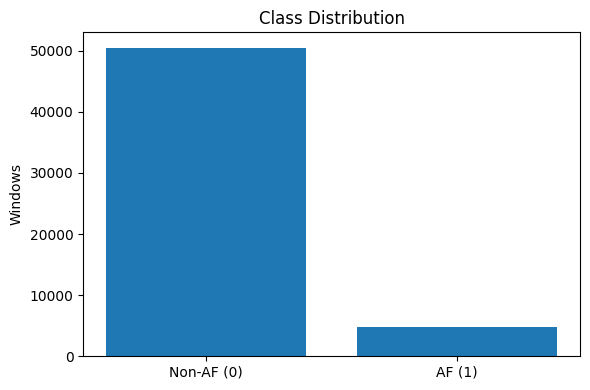

/usr/local/lib/python3.12/dist-packages/numpy/lib/histograms.py:885: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/usr/local/lib/python3.12/dist-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


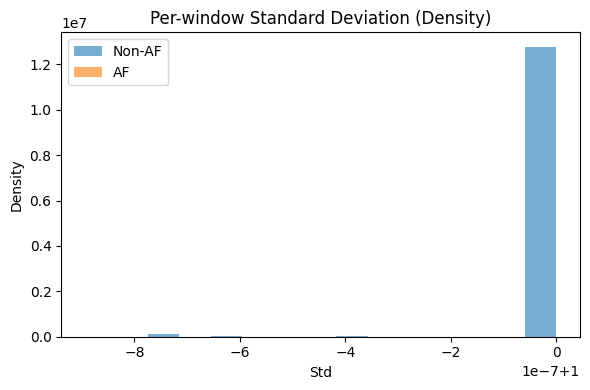

/tmp/ipython-input-4124932665.py:100: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([zcr_per_sec[y==0], zcr_per_sec[y==1]], labels=["Non-AF", "AF"], showfliers=False)


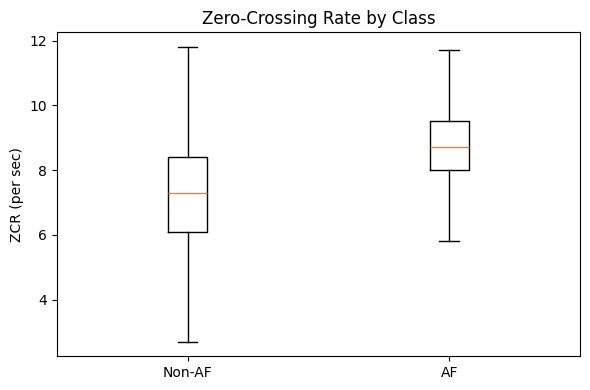

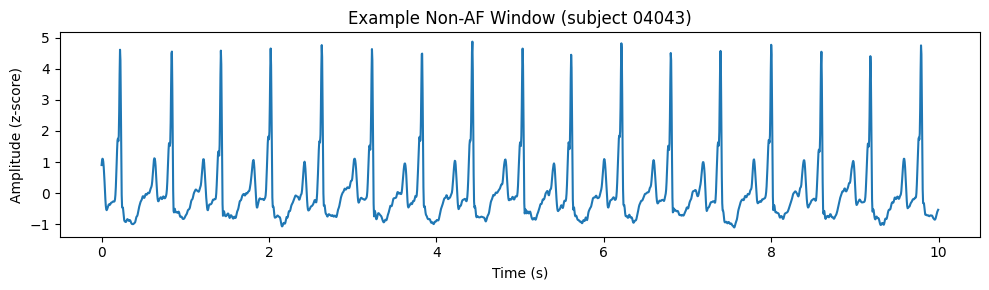

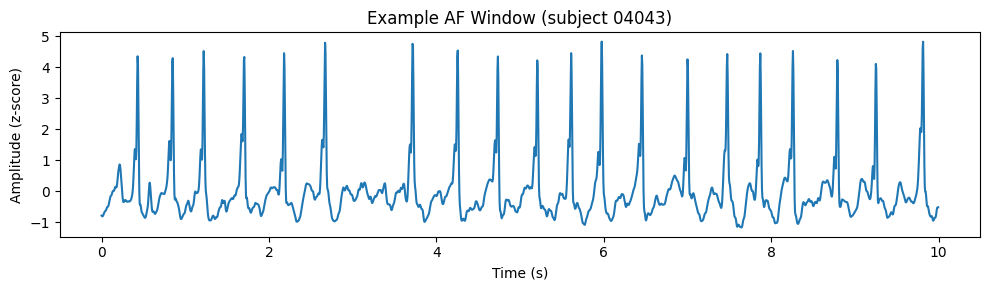

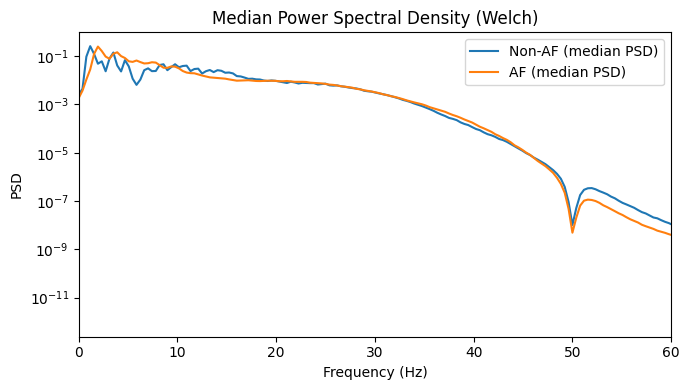


Class-wise stats (std):


,class,mean,std,median,p25,p75,n
0,Non-AF,1.0,1.150891e-07,1.0,1.0,1.0,50470
1,AF,1.0,5.512701e-08,1.0,1.0,1.0,4751



Class-wise stats (ptp):


,class,mean,std,median,p25,p75,n
0,Non-AF,7.841500,1.266344,8.256934,6.396120,8.713437,50470
1,AF,6.637335,0.811082,6.401830,6.205099,6.687860,4751



Class-wise stats (rms):


,class,mean,std,median,p25,p75,n
0,Non-AF,1.0,1.150900e-07,1.0,1.0,1.0,50470
1,AF,1.0,5.511344e-08,1.0,1.0,1.0,4751



Class-wise stats (zcr):


,class,mean,std,median,p25,p75,n
0,Non-AF,7.858381,3.145655,7.303652,6.103052,8.404202,50470
1,AF,9.024845,1.943569,8.704352,8.004002,9.504752,4751



Suggested class_weights for training: {0: 0.5470675648900337, 1: 5.81151336560724}

EDA Artifacts saved under: /content/afdb_eda


In [4]:
# =========================
# AFDB EDA
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import welch

# --- sanity checks (expects X, y, subjects in memory) ---
if "X" not in globals() or "y" not in globals() or "subjects" not in globals():
    raise RuntimeError("Please run the data loader first to define X, y, subjects.")

X = np.asarray(X); y = np.asarray(y).astype(int); subjects = np.asarray(subjects)
assert X.ndim == 3 and X.shape[-1] == 1, f"Expected X=(n, win_len, 1). Got {X.shape}"

FS = 200.0                           # Hz (set to None if you want to infer)
if FS is None:                       # naive inference if needed
    FS = 200.0
win_len = X.shape[1]
WIN_SEC = win_len / FS

artifacts_dir = Path("./afdb_eda")
artifacts_dir.mkdir(parents=True, exist_ok=True)

# ---------------- Basic summaries ----------------
summary = {
    "n_windows": int(X.shape[0]),
    "window_len_samples": int(win_len),
    "fs_hz": FS,
    "window_duration_sec": WIN_SEC,
    "n_subjects": int(np.unique(subjects).size),
    "class_positives": int(y.sum()),
    "class_negatives": int((y==0).sum()),
    "class_pos_ratio": float(y.mean()),
}
summary_df = pd.DataFrame([summary])
summary_df.to_csv(artifacts_dir / "summary_overall.csv", index=False)
display(summary_df)

# ---------------- Per-subject distribution ----------------
subj_df = pd.DataFrame({"subject": subjects, "label": y})
subj_grp = subj_df.groupby("subject").agg(
    windows=("label", "size"),
    af_windows=("label", "sum")
).reset_index()
subj_grp["af_ratio"] = subj_grp["af_windows"] / subj_grp["windows"]
subj_grp = subj_grp.sort_values("af_ratio", ascending=False)
subj_grp.to_csv(artifacts_dir / "summary_per_subject.csv", index=False)
display(subj_grp.head(10))

# ---------------- Window-level signal stats ----------------
x2d = X[..., 0]               # (n, win_len)
win_mean = x2d.mean(axis=1)
win_std  = x2d.std(axis=1)
win_ptp  = x2d.ptp(axis=1)    # peak-to-peak
win_rms  = np.sqrt((x2d**2).mean(axis=1))

# zero-crossing rate per second
signs = np.sign(x2d)
sign_changes = (np.diff(signs, axis=1) != 0).sum(axis=1)
zcr_per_sec = (sign_changes / (win_len - 1)) * FS

stats_df = pd.DataFrame({
    "subject": subjects,
    "label": y,
    "mean": win_mean,
    "std": win_std,
    "ptp": win_ptp,
    "rms": win_rms,
    "zcr_per_sec": zcr_per_sec
})
stats_df.to_csv(artifacts_dir / "summary_window_stats.csv", index=False)
display(stats_df.head())

# ---------------- Plots ----------------
# Class distribution
plt.figure(figsize=(6,4))
plt.bar(["Non-AF (0)", "AF (1)"], [(y==0).sum(), (y==1).sum()])
plt.title("Class Distribution")
plt.ylabel("Windows")
plt.tight_layout()
plt.savefig(artifacts_dir / "class_distribution.png", dpi=150)
plt.show()

#  Hist overlay: per-window std by class
plt.figure(figsize=(6,4))
_ = plt.hist(win_std[y==0], bins=60, alpha=0.6, density=True, label="Non-AF")
_ = plt.hist(win_std[y==1], bins=60, alpha=0.6, density=True, label="AF")
plt.title("Per-window Standard Deviation (Density)")
plt.xlabel("Std")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.savefig(artifacts_dir / "hist_std_overlay.png", dpi=150)
plt.show()

# Boxplot: ZCR by class
plt.figure(figsize=(6,4))
plt.boxplot([zcr_per_sec[y==0], zcr_per_sec[y==1]], labels=["Non-AF", "AF"], showfliers=False)
plt.title("Zero-Crossing Rate by Class")
plt.ylabel("ZCR (per sec)")
plt.tight_layout()
plt.savefig(artifacts_dir / "boxplot_zcr_by_class.png", dpi=150)
plt.show()

# Time strips (one per class)
rng = np.random.default_rng(1337)
idx_nonaf = rng.choice(np.where(y==0)[0])
idx_af    = rng.choice(np.where(y==1)[0])
t = np.arange(win_len) / FS

plt.figure(figsize=(10,3))
plt.plot(t, x2d[idx_nonaf])
plt.title(f"Example Non-AF Window (subject {subjects[idx_nonaf]})")
plt.xlabel("Time (s)"); plt.ylabel("Amplitude (z-score)")
plt.tight_layout()
plt.savefig(artifacts_dir / "example_nonaf_strip.png", dpi=150)
plt.show()

plt.figure(figsize=(10,3))
plt.plot(t, x2d[idx_af])
plt.title(f"Example AF Window (subject {subjects[idx_af]})")
plt.xlabel("Time (s)"); plt.ylabel("Amplitude (z-score)")
plt.tight_layout()
plt.savefig(artifacts_dir / "example_af_strip.png", dpi=150)
plt.show()

# 5) Median PSD overlay (Welch) for AF vs Non-AF (sample for speed)
N = 800
idx0 = np.where(y==0)[0]; idx1 = np.where(y==1)[0]
if idx0.size > N: idx0 = rng.choice(idx0, size=N, replace=False)
if idx1.size > N: idx1 = rng.choice(idx1, size=N, replace=False)

def median_psd(batch, fs, nperseg=512):
    psds = []
    for row in batch:
        f, Pxx = welch(row, fs=fs, nperseg=min(nperseg, len(row)))
        psds.append(Pxx)
    psds = np.vstack(psds)
    return f, np.median(psds, axis=0)

f0, med0 = median_psd(x2d[idx0], FS)
f1, med1 = median_psd(x2d[idx1], FS)

plt.figure(figsize=(7,4))
plt.semilogy(f0, med0, label="Non-AF (median PSD)")
plt.semilogy(f1, med1, label="AF (median PSD)")
plt.title("Median Power Spectral Density (Welch)")
plt.xlabel("Frequency (Hz)"); plt.ylabel("PSD")
plt.xlim(0, 60)
plt.legend()
plt.tight_layout()
plt.savefig(artifacts_dir / "median_psd_overlay.png", dpi=150)
plt.show()

# ---------------- Class-wise descriptive stats ----------------
def describe_by_class(values, labels):
    return pd.DataFrame({
        "class": ["Non-AF", "AF"],
        "mean": [values[labels==0].mean(), values[labels==1].mean()],
        "std":  [values[labels==0].std(),  values[labels==1].std()],
        "median":[np.median(values[labels==0]), np.median(values[labels==1])],
        "p25":  [np.percentile(values[labels==0], 25), np.percentile(values[labels==1], 25)],
        "p75":  [np.percentile(values[labels==0], 75), np.percentile(values[labels==1], 75)],
        "n":    [(labels==0).sum(), (labels==1).sum()],
    })

class_stats_std  = describe_by_class(win_std, y)
class_stats_ptp  = describe_by_class(win_ptp, y)
class_stats_rms  = describe_by_class(win_rms, y)
class_stats_zcr  = describe_by_class(zcr_per_sec, y)

class_stats_std.to_csv(artifacts_dir / "class_stats_std.csv", index=False)
class_stats_ptp.to_csv(artifacts_dir / "class_stats_ptp.csv", index=False)
class_stats_rms.to_csv(artifacts_dir / "class_stats_rms.csv", index=False)
class_stats_zcr.to_csv(artifacts_dir / "class_stats_zcr.csv", index=False)

print("\nClass-wise stats (std):"); display(class_stats_std)
print("\nClass-wise stats (ptp):"); display(class_stats_ptp)
print("\nClass-wise stats (rms):"); display(class_stats_rms)
print("\nClass-wise stats (zcr):"); display(class_stats_zcr)

# ---------------- Suggested class weights for training ----------------
neg = (y==0).sum(); pos = (y==1).sum(); n = len(y)
class_weights = {0: n/(2*neg), 1: n/(2*pos)}
print("\nSuggested class_weights for training:", class_weights)

print(f"\nEDA Artifacts saved under: {artifacts_dir.resolve()}")


In [5]:
import torch.nn as nn
class BinaryFocalLoss(nn.Module):
    def __init__(self, alpha=0.9, gamma=2.0):
        super().__init__(); self.alpha=alpha; self.gamma=gamma
    def forward(self, logits, targets):
        p = torch.sigmoid(logits)
        ce_pos = -targets * torch.log(p.clamp_min(1e-7))
        ce_neg = -(1-targets) * torch.log((1-p).clamp_min(1e-7))
        loss = self.alpha*(1-p)**self.gamma*ce_pos + (1-self.alpha)*p**self.gamma*ce_neg
        return loss.mean()

# alpha guidance: make it proportional to minority prevalence weight
neg = (y==0).sum(); pos = (y==1).sum()
alpha = float(neg/(neg+pos))  # ~0.914 for our split
criterion = BinaryFocalLoss(alpha=alpha, gamma=2.0)

@tf.function
def binary_focal_loss(alpha=0.9, gamma=2.0):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1-1e-7)
        ce_pos = -y_true * tf.math.log(y_pred)
        ce_neg = -(1-y_true) * tf.math.log(1-y_pred)
        return tf.reduce_mean(alpha*tf.pow(1-y_pred, gamma)*ce_pos +
                              (1-alpha)*tf.pow(y_pred, gamma)*ce_neg)
    return loss

neg = (y==0).sum(); pos = (y==1).sum()
alpha = float(neg/(neg+pos))


In [6]:
# ====================== CLEAN CNN+LSTM TRAINER (fixed shapes) ======================
import numpy as np, torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# -------------------- Dataset --------------------
class ECGWindows(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(np.asarray(X)).float()   # (N, T, 1)
        self.y = torch.from_numpy(np.asarray(y)).float()   # (N,)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i):
        xi = self.X[i].transpose(0, 1)   # (T,1) -> (1,T) for Conv1d
        yi = self.y[i]                   # scalar float (0./1.)
        return xi, yi

# -------------------- Model --------------------
class CNNLSTM1D(nn.Module):
    def __init__(self, in_ch=1, lstm_hidden=64, lstm_layers=1, p_drop=0.2):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_ch, 32, kernel_size=7, padding=3), nn.ReLU(), nn.BatchNorm1d(32),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, kernel_size=5, padding=2), nn.ReLU(), nn.BatchNorm1d(64),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 64, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm1d(64),
            nn.Dropout(p_drop),
        )
        self.lstm = nn.LSTM(input_size=64, hidden_size=lstm_hidden,
                            num_layers=lstm_layers, batch_first=True, bidirectional=False)
        self.head = nn.Sequential(
            nn.Linear(lstm_hidden, 64), nn.ReLU(), nn.Dropout(p_drop),
            nn.Linear(64, 1)  # 1 logit
        )
    def forward(self, x):         # x: (B, 1, T)
        x = self.conv(x)          # (B, 64, T')
        x = x.permute(0, 2, 1)    # (B, T', 64)
        out, _ = self.lstm(x)     # (B, T', H)
        h_last = out[:, -1, :]    # (B, H)
        logit = self.head(h_last) # (B, 1)
        return logit.squeeze(1)   # (B,)

# -------------------- Split (subject-wise) --------------------
X_np = np.asarray(X, dtype=np.float32)
y_np = np.asarray(y, dtype=np.int64)
groups = np.asarray(subjects)

gkf = GroupKFold(n_splits=3)  # adjust when you have more subjects
train_idx, val_idx = next(gkf.split(X_np, y_np, groups=groups))

X_tr, y_tr = X_np[train_idx], y_np[train_idx]
X_va, y_va = X_np[val_idx],  y_np[val_idx]

# -------------------- Loaders --------------------
USE_BALANCED_SAMPLER = False    # set True to oversample positives in training
BATCH_SIZE = 256
use_cuda = torch.cuda.is_available()

train_ds = ECGWindows(X_tr, y_tr)
val_ds   = ECGWindows(X_va, y_va)

if USE_BALANCED_SAMPLER:
    labels = y_tr.astype(int)
    w_pos = (labels==0).sum() / max(1, (labels==1).sum())
    w = np.where(labels==1, w_pos, 1.0).astype(np.float32)
    sampler = WeightedRandomSampler(weights=torch.from_numpy(w),
                                    num_samples=len(w), replacement=True)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler,
                              num_workers=2 if use_cuda else 0, pin_memory=use_cuda)
else:
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=2 if use_cuda else 0, pin_memory=use_cuda)

val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=2 if use_cuda else 0, pin_memory=use_cuda)

# -------------------- Loss/Opt (pos_weight from TRAIN ONLY) --------------------
device = torch.device("cuda" if use_cuda else "cpu")
model = CNNLSTM1D().to(device)

neg = (y_tr==0).sum(); pos = (y_tr==1).sum()
pos_weight = torch.tensor(neg/max(1,pos), dtype=torch.float32, device=device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

print(f"Device: {device} | Train counts: neg={neg}, pos={pos} | pos_weight={pos_weight.item():.3f}")

# -------------------- Train / Eval helpers --------------------
def evaluate(loader, threshold=0.5):
    model.eval()
    y_true_all, y_prob_all = [], []
    total_loss = 0.0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)                    # (B,1,T)
            yb = yb.to(device)                    # (B,)
            logits = model(xb)                    # (B,)
            loss = criterion(logits, yb)
            total_loss += loss.item() * yb.size(0)
            y_true_all.append(yb.cpu().numpy())
            y_prob_all.append(torch.sigmoid(logits).cpu().numpy())
    y_true = np.concatenate(y_true_all).astype(int)
    y_prob = np.concatenate(y_prob_all)
    y_pred = (y_prob >= threshold).astype(int)
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred)
    pre = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    return total_loss/len(y_true), acc, f1, pre, rec, y_true, y_prob

def best_f1_threshold(y_true, y_prob):
    # quick grid search for best F1 threshold
    ts = np.linspace(0.05, 0.95, 19)
    best_t, best_f1 = 0.5, -1
    for t in ts:
        f1 = f1_score(y_true, (y_prob>=t).astype(int))
        if f1 > best_f1:
            best_f1, best_t = f1, t
    return best_t, best_f1

# -------------------- Training loop --------------------
EPOCHS = 8
best_state, best_val_f1 = None, -1
val_thresh = 0.5

for ep in range(1, EPOCHS+1):
    model.train()
    run_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device)                 # (B,1,T)
        yb = yb.to(device)                 # (B,)
        optimizer.zero_grad()
        logits = model(xb)                 # (B,)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        run_loss += loss.item() * yb.size(0)

    tr_loss, tr_acc, tr_f1, tr_p, tr_r, _, _ = evaluate(train_loader, threshold=val_thresh)
    va_loss, va_acc, va_f1, va_p, va_r, yv_true, yv_prob = evaluate(val_loader, threshold=val_thresh)

    # Tune threshold on validation each epoch (optional but helpful with imbalance)
    t_new, f1_new = best_f1_threshold(yv_true, yv_prob)
    if f1_new > va_f1:
        va_f1, val_thresh = f1_new, t_new

    if va_f1 > best_val_f1:
        best_val_f1 = va_f1
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}

    print(f"[{ep:02d}] train: loss={tr_loss:.4f} acc={tr_acc:.3f} f1={tr_f1:.3f} "
          f"P={tr_p:.3f} R={tr_r:.3f} | val: loss={va_loss:.4f} acc={va_acc:.3f} "
          f"f1={va_f1:.3f} P={va_p:.3f} R={va_r:.3f} (thr={val_thresh:.2f})")

# load best state
if best_state is not None:
    model.load_state_dict(best_state)
print("Best val F1:", best_val_f1)
# ================================================================================


Device: cpu | Train counts: neg=32278, pos=4536 | pos_weight=7.116
[01] train: loss=0.9868 acc=0.496 f1=0.320 P=0.192 R=0.964 | val: loss=0.7708 acc=0.504 f1=0.024 P=0.012 R=0.493 (thr=0.25)
[02] train: loss=0.8096 acc=0.570 f1=0.360 P=0.220 R=0.980 | val: loss=0.8719 acc=0.359 f1=0.021 P=0.010 R=0.526 (thr=0.05)
[03] train: loss=0.8047 acc=0.421 f1=0.297 P=0.175 R=0.993 | val: loss=0.7478 acc=0.090 f1=0.026 P=0.012 R=0.963 (thr=0.35)
[04] train: loss=0.3632 acc=0.908 f1=0.717 P=0.576 R=0.951 | val: loss=0.8354 acc=0.472 f1=0.022 P=0.009 R=0.386 (thr=0.95)
[05] train: loss=0.3764 acc=0.967 f1=0.870 P=0.854 R=0.885 | val: loss=0.2956 acc=0.988 f1=0.051 P=0.667 R=0.009 (thr=0.60)
[06] train: loss=0.3444 acc=0.958 f1=0.846 P=0.776 R=0.929 | val: loss=0.3141 acc=0.983 f1=0.030 P=0.010 R=0.005 (thr=0.15)
[07] train: loss=0.3103 acc=0.952 f1=0.830 P=0.739 R=0.947 | val: loss=0.3541 acc=0.887 f1=0.027 P=0.003 R=0.028 (thr=0.85)
[08] train: loss=0.3112 acc=0.965 f1=0.866 P=0.813 R=0.926 | val:

In [7]:
import tensorflow as tf

def build_cnn_lstm(
    input_length=2000,
    n_channels=1,
    conv_filters=(32, 64, 64),
    kernel_sizes=(7, 5, 3),
    pool_size=2,
    dropout=0.2,
    lstm_units=64,
    l2_reg=1e-6,
    name="cnn_lstm_afib"
):
    inp = tf.keras.Input(shape=(input_length, n_channels))

    x = inp
    for f, k in zip(conv_filters, kernel_sizes):
        x = tf.keras.layers.Conv1D(
            filters=f, kernel_size=k, padding="same",
            kernel_regularizer=tf.keras.regularizers.l2(l2_reg)
        )(x)
        x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling1D(pool_size=pool_size)(x)
        x = tf.keras.layers.Dropout(dropout)(x)

    # Gentle normalization before temporal modeling
    x = tf.keras.layers.LayerNormalization(epsilon=1e-5)(x)

    # Temporal context
    x = tf.keras.layers.LSTM(
        lstm_units, dropout=dropout, recurrent_dropout=0.0,
        return_sequences=False
    )(x)

    # Small head
    x = tf.keras.layers.Dense(
        64, activation="relu",
        kernel_regularizer=tf.keras.regularizers.l2(l2_reg)
    )(x)
    x = tf.keras.layers.Dropout(dropout)(x)

    # Binary output (sigmoid)
    out = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inp, out, name=name)
    return model

# ---- build + compile (uses your dataset tensors X, y, subjects) ----
model = build_cnn_lstm(input_length=X.shape[1], n_channels=X.shape[2])
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), "accuracy"]
)


Model: "cnn_lstm_afib"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2000, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 2000, 32)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 2000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2000, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1000, 64)       │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 1000, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1000, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 500, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 500, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 500, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 500, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 500, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 250, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 250, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 250, 64)        │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,929 (238.00 KB)

 Trainable params: 60,609 (236.75 KB)

 Non-trainable params: 320 (1.25 KB)

In [8]:
# class weights from your labels
def compute_class_weight(y):
    import numpy as np
    y = np.asarray(y).astype(int)
    n = len(y); pos = (y==1).sum(); neg = n - pos
    return {0: n/(2*neg), 1: n/(2*pos)}

class_weight = compute_class_weight(y)
print(class_weight)

# in-memory dataset
import numpy as np, tensorflow as tf
X_tf = tf.convert_to_tensor(X, dtype=tf.float32)   # (n, T, 1)
y_tf = tf.convert_to_tensor(y, dtype=tf.int32)
ds = tf.data.Dataset.from_tensor_slices((X_tf, y_tf)).shuffle(10000).batch(256).prefetch(tf.data.AUTOTUNE)

# train with class weights
model.fit(ds, epochs=10, class_weight=class_weight)

# oversample positives for balanced batches — use this OR class_weight (not both)
pos = X[y==1]; neg = X[y==0]
pos_ds = tf.data.Dataset.from_tensor_slices((pos, np.ones(len(pos), np.int32))).repeat()
neg_ds = tf.data.Dataset.from_tensor_slices((neg, np.zeros(len(neg), np.int32))).repeat()
balanced = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
balanced = balanced.shuffle(10000).batch(256).prefetch(tf.data.AUTOTUNE)

# ================= Balanced training stream (no class_weight) =================
import numpy as np
import tensorflow as tf

# --- split X into positives/negatives ---
pos_idx = np.where(y == 1)[0]
neg_idx = np.where(y == 0)[0]

pos = X[pos_idx]                                    # (n_pos, T, 1)
neg = X[neg_idx]                                    # (n_neg, T, 1)

# labels as float32 column vectors
ones  = np.ones((len(pos_idx), 1), dtype=np.float32)
zeros = np.zeros((len(neg_idx), 1), dtype=np.float32)

# --- build tf.data datasets (repeat -> infinite) ---
pos_ds = tf.data.Dataset.from_tensor_slices((pos,  ones)).repeat()
neg_ds = tf.data.Dataset.from_tensor_slices((neg, zeros)).repeat()

# cast to float32 (defensive), keep shapes (T, 1) and (1,)
def _to_float(x, y):
    return tf.cast(x, tf.float32), tf.cast(y, tf.float32)

pos_ds = pos_ds.map(_to_float, num_parallel_calls=tf.data.AUTOTUNE)
neg_ds = neg_ds.map(_to_float, num_parallel_calls=tf.data.AUTOTUNE)

# --- 50/50 balanced mixture ---
BATCH_SIZE = 256
balanced = tf.data.Dataset.sample_from_datasets(
    [pos_ds, neg_ds], weights=[0.5, 0.5], seed=1337
).shuffle(10000, seed=1337).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# --- separate validation on the full (natural, imbalanced) set ---
val_ds = tf.data.Dataset.from_tensor_slices(
    (tf.cast(X, tf.float32), tf.cast(y.reshape(-1, 1), tf.float32))
).batch(512).prefetch(tf.data.AUTOTUNE)

# --- compile (include PR-AUC to track minority performance) ---
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(curve="PR",  name="pr_auc"),
        tf.keras.metrics.AUC(curve="ROC", name="roc_auc"),
        "accuracy",
    ],
)

# --- training ---
EPOCHS = 10
# Because the stream is infinite, specify steps_per_epoch.
# A good default is roughly one pass worth of windows:
steps_per_epoch = int(np.ceil(len(X) / BATCH_SIZE))

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, min_lr=1e-5, monitor="val_pr_auc", mode="max"),
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_pr_auc", mode="max"),
]

history = model.fit(
    balanced,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_ds,     # evaluates on natural distribution
    callbacks=callbacks,
)
# ============================================================================



{0: 0.5470675648900337, 1: 5.81151336560724}
Epoch 1/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 624s 3s/step - accuracy: 0.8973 - loss: 0.3080 - precision: 0.3244 - recall: 0.6002
Epoch 2/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 614s 3s/step - accuracy: 0.9507 - loss: 0.2051 - precision: 0.5121 - recall: 0.8322
Epoch 3/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 624s 3s/step - accuracy: 0.8922 - loss: 0.2459 - precision: 0.3317 - recall: 0.8613
Epoch 4/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 605s 3s/step - accuracy: 0.9359 - loss: 0.1917 - precision: 0.4452 - recall: 0.8232
Epoch 5/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 620s 3s/step - accuracy: 0.9515 - loss: 0.1524 - precision: 0.5053 - recall: 0.8883
Epoch 6/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 627s 3s/step - accuracy: 0.9311 - loss: 0.1781 - precision: 0.4485 - recall: 0.8440
Epoch 7/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 620s 3s/step - accuracy: 0.9563 - loss: 0.1507 - precision: 0.5431 - recall: 0.9035
Epoch 8/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 605s 3s/step - accuracy: 0.9570 - loss: 0.1476 

== Metrics (threshold = 0.50) ==
   acc: 0.9724
  prec: 0.7718
   rec: 0.9638
    f1: 0.8572
Confusion matrix @0.50:
 [[49116  1354]
 [  172  4579]]

== Metrics (best F1 threshold) ==
threshold: 0.9500
      acc: 0.9778
     prec: 0.8521
      rec: 0.8977
       f1: 0.8743
Confusion matrix @best-thr:
 [[49730   740]
 [  486  4265]]

== Classification report @best-thr ==
              precision    recall  f1-score   support

           0     0.9903    0.9853    0.9878     50470
           1     0.8521    0.8977    0.8743      4751

    accuracy                         0.9778     55221
   macro avg     0.9212    0.9415    0.9311     55221
weighted avg     0.9784    0.9778    0.9781     55221


ROC AUC: 0.9881 | PR AUC: 0.8915 | AP: 0.8916


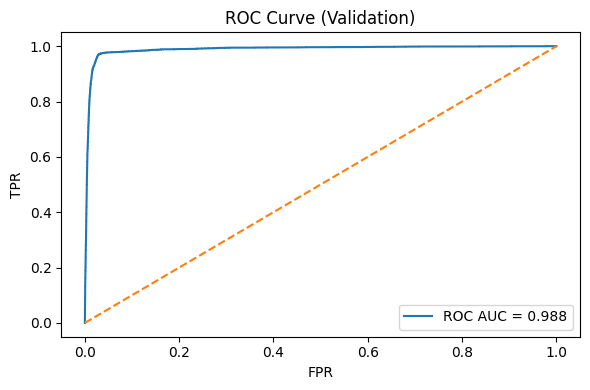

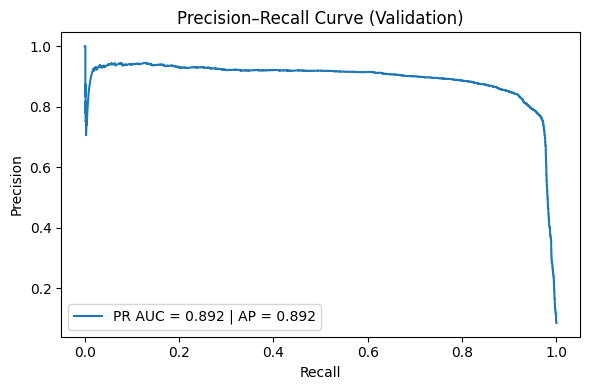

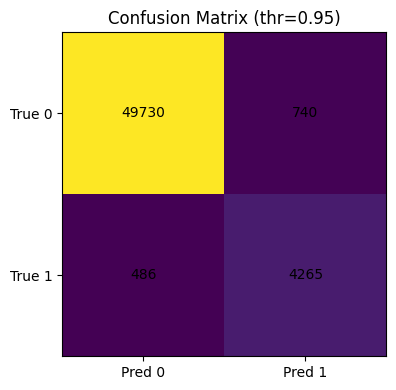

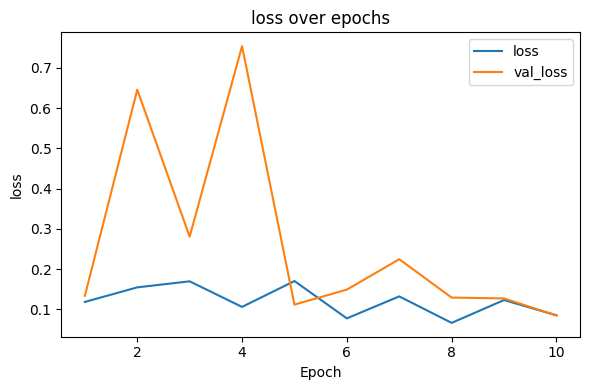

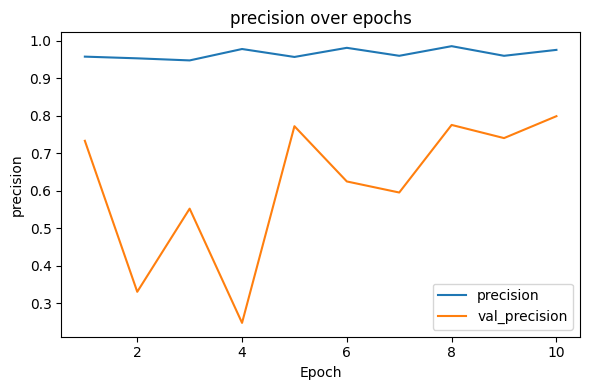

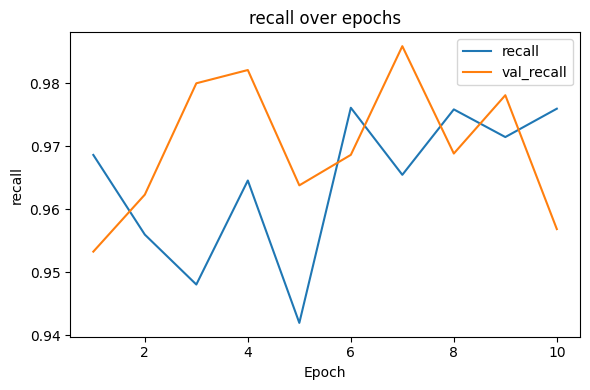

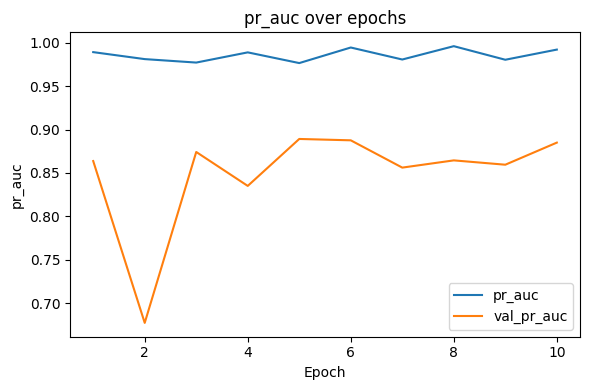

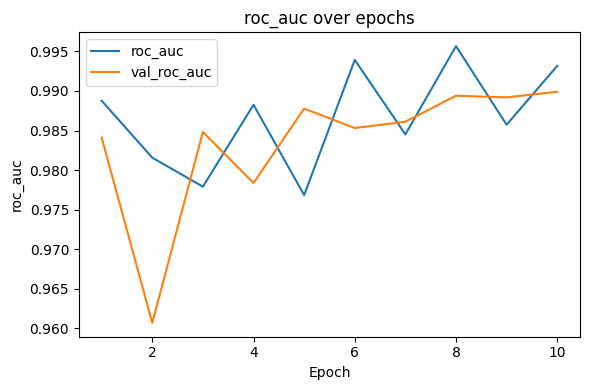

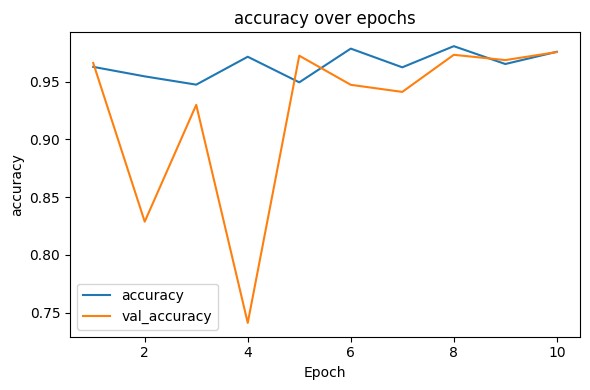


Saved figures to: /content/afdb_eval


In [9]:
# ======================= Keras evaluation & plots =======================
import numpy as np, matplotlib.pyplot as plt, os
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve, average_precision_score
)
-
# --- Collect y_true and y_prob from validation data ---
y_true_list, y_prob_list = [], []
for xb, yb in val_ds:
    p = model.predict(xb, verbose=0).reshape(-1)   # sigmoid probs
    y_prob_list.append(p)
    y_true_list.append(yb.numpy().reshape(-1))
y_true = np.concatenate(y_true_list).astype(int)
y_prob = np.concatenate(y_prob_list)

# --- Helper to compute metrics at a threshold ---
def metrics_at_threshold(y_true, y_prob, thr=0.5):
    y_pred = (y_prob >= thr).astype(int)
    return dict(
        threshold=thr,
        acc=accuracy_score(y_true, y_pred),
        prec=precision_score(y_true, y_pred, zero_division=0),
        rec=recall_score(y_true, y_pred, zero_division=0),
        f1=f1_score(y_true, y_pred, zero_division=0),
        cm=confusion_matrix(y_true, y_pred)
    )

# --- Find best F1 threshold (simple grid search) ---
ths = np.linspace(0.05, 0.95, 19)
best = max((metrics_at_threshold(y_true, y_prob, t) for t in ths), key=lambda d: d["f1"])
base = metrics_at_threshold(y_true, y_prob, 0.5)

print("== Metrics (threshold = 0.50) ==")
for k in ["acc","prec","rec","f1"]:
    print(f"{k:>6}: {base[k]:.4f}")
print("Confusion matrix @0.50:\n", base["cm"])

print("\n== Metrics (best F1 threshold) ==")
for k in ["threshold","acc","prec","rec","f1"]:
    v = best[k]; print(f"{k:>9}: {v:.4f}" if isinstance(v, float) else f"{k:>9}: {v}")
print("Confusion matrix @best-thr:\n", best["cm"])

print("\n== Classification report @best-thr ==")
print(classification_report(y_true, (y_prob >= best["threshold"]).astype(int), digits=4))

# --- ROC & PR curves ---
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

prec, rec, _ = precision_recall_curve(y_true, y_prob)
pr_auc = auc(rec, prec)
ap = average_precision_score(y_true, y_prob)

print(f"\nROC AUC: {roc_auc:.4f} | PR AUC: {pr_auc:.4f} | AP: {ap:.4f}")

# --- Make an output folder ---
outdir = "./afdb_eval"
os.makedirs(outdir, exist_ok=True)

# --- Plot ROC ---
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("ROC Curve (Validation)")
plt.legend(loc="lower right")
plt.tight_layout(); plt.savefig(os.path.join(outdir, "roc_curve.png"), dpi=150)
plt.show()

# --- Plot Precision-Recall ---
plt.figure(figsize=(6,4))
plt.plot(rec, prec, label=f"PR AUC = {pr_auc:.3f} | AP = {ap:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Validation)")
plt.legend(loc="lower left")
plt.tight_layout(); plt.savefig(os.path.join(outdir, "pr_curve.png"), dpi=150)
plt.show()

# --- Confusion matrix @ best threshold ---
cm = best["cm"]
plt.figure(figsize=(4.5,4))
plt.imshow(cm, interpolation="nearest")
plt.title(f"Confusion Matrix (thr={best['threshold']:.2f})")
plt.xticks([0,1], ["Pred 0","Pred 1"]); plt.yticks([0,1], ["True 0","True 1"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i,j]), ha="center", va="center")
plt.tight_layout(); plt.savefig(os.path.join(outdir, "confusion_matrix.png"), dpi=150)
plt.show()

# ---------------- Per-epoch training curves ----------------
# history.history should contain: loss, precision, recall, pr_auc, roc_auc (+ val_* versions)
hist = history.history
epochs = np.arange(1, len(hist.get("loss", [])) + 1)

def plot_metric(name, ylabel=None):
    if name not in hist:
        print(f"(skip) '{name}' not in history"); return
    plt.figure(figsize=(6,4))
    plt.plot(epochs, hist[name], label=name)
    val_name = "val_" + name
    if val_name in hist:
        plt.plot(epochs, hist[val_name], label=val_name)
    plt.xlabel("Epoch"); plt.ylabel(ylabel or name); plt.title(f"{name} over epochs")
    plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(outdir, f"{name}_epochs.png"), dpi=150)
    plt.show()

for m in ["loss","precision","recall","pr_auc","roc_auc","accuracy"]:
    plot_metric(m)

print(f"\nSaved figures to: {os.path.abspath(outdir)}")
# ======================================================================


== Metrics (threshold = 0.50) ==
   acc: 0.9724
  prec: 0.7718
   rec: 0.9638
    f1: 0.8572
Confusion matrix @0.50:
 [[49116  1354]
 [  172  4579]]

== Metrics (best F1 threshold) ==
threshold: 0.9500
      acc: 0.9778
     prec: 0.8521
      rec: 0.8977
       f1: 0.8743
Confusion matrix @best-thr:
 [[49730   740]
 [  486  4265]]

== Classification report @best-thr ==
              precision    recall  f1-score   support

           0     0.9903    0.9853    0.9878     50470
           1     0.8521    0.8977    0.8743      4751

    accuracy                         0.9778     55221
   macro avg     0.9212    0.9415    0.9311     55221
weighted avg     0.9784    0.9778    0.9781     55221


ROC AUC: 0.9881 | PR AUC: 0.8915 | AP: 0.8916


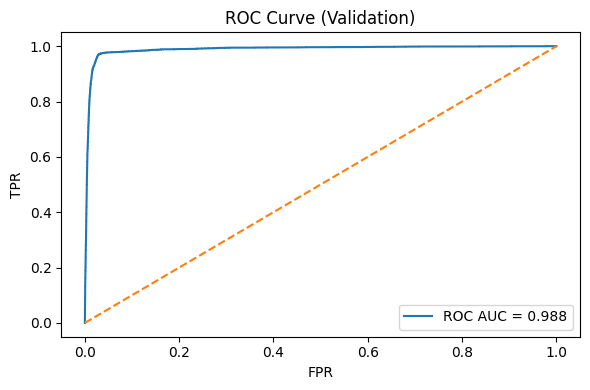

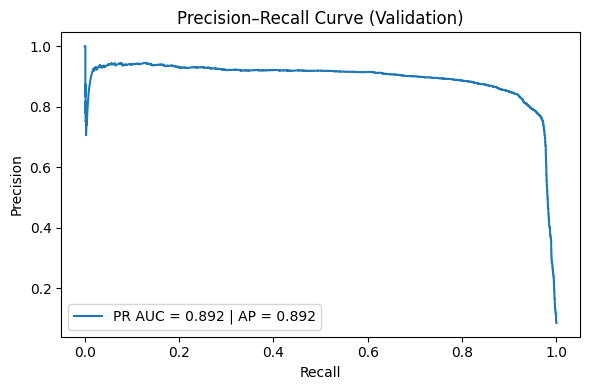

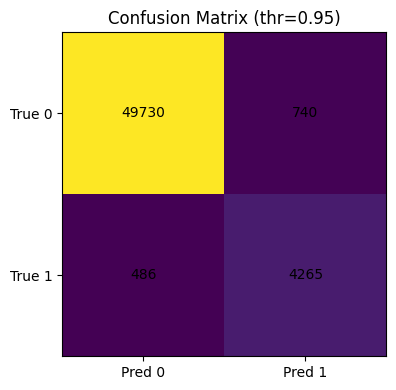

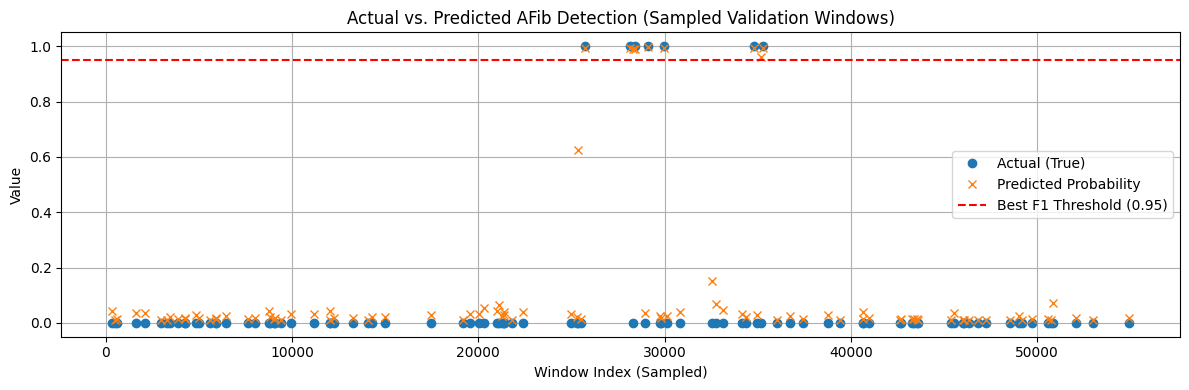


Saved figures to: /content/afdb_eval


In [10]:
# ======================= Keras evaluation & plots (TensorFlow model) =======================
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve, average_precision_score
)

# --- Collect y_true and y_prob from validation data ---
if 'val_ds' not in globals():
    raise RuntimeError("Validation dataset 'val_ds' not found. Please run the data loading and preparation cells first.")

y_true_list, y_prob_list = [], []
for xb, yb in val_ds:
    # model.predict returns probabilities directly since the output layer is sigmoid
    p = model.predict(xb, verbose=0).reshape(-1)
    y_prob_list.append(p)
    y_true_list.append(yb.numpy().reshape(-1))

y_true = np.concatenate(y_true_list).astype(int)
y_prob = np.concatenate(y_prob_list)

# --- Helper to compute metrics at a threshold ---
def metrics_at_threshold(y_true, y_prob, thr=0.5):
    y_pred = (y_prob >= thr).astype(int)
    return dict(
        threshold=thr,
        acc=accuracy_score(y_true, y_pred),
        prec=precision_score(y_true, y_pred, zero_division=0),
        rec=recall_score(y_true, y_pred, zero_division=0),
        f1=f1_score(y_true, y_pred, zero_division=0),
        cm=confusion_matrix(y_true, y_pred)
    )

# --- Find best F1 threshold (simple grid search) ---
ths = np.linspace(0.05, 0.95, 19)
best = max((metrics_at_threshold(y_true, y_prob, t) for t in ths), key=lambda d: d["f1"])
base = metrics_at_threshold(y_true, y_prob, 0.5)

print("== Metrics (threshold = 0.50) ==")
for k in ["acc","prec","rec","f1"]:
    print(f"{k:>6}: {base[k]:.4f}")
print("Confusion matrix @0.50:\n", base["cm"])

print("\n== Metrics (best F1 threshold) ==")
for k in ["threshold","acc","prec","rec","f1"]:
    v = best[k]; print(f"{k:>9}: {v:.4f}" if isinstance(v, float) else f"{k:>9}: {v}")
print("Confusion matrix @best-thr:\n", best["cm"])

print("\n== Classification report @best-thr ==")
print(classification_report(y_true, (y_prob >= best["threshold"]).astype(int), digits=4))

# --- ROC & PR curves ---
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

prec, rec, _ = precision_recall_curve(y_true, y_prob)
pr_auc = auc(rec, prec)
ap = average_precision_score(y_true, y_prob)

print(f"\nROC AUC: {roc_auc:.4f} | PR AUC: {pr_auc:.4f} | AP: {ap:.4f}")

# --- Make an output folder ---
outdir = "./afdb_eval"
os.makedirs(outdir, exist_ok=True)

# --- Plot ROC ---
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("ROC Curve (Validation)")
plt.legend(loc="lower right")
plt.tight_layout(); plt.savefig(os.path.join(outdir, "roc_curve.png"), dpi=150)
plt.show()

# --- Plot Precision-Recall ---
plt.figure(figsize=(6,4))
plt.plot(rec, prec, label=f"PR AUC = {pr_auc:.3f} | AP = {ap:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Validation)")
plt.legend(loc="lower left")
plt.tight_layout(); plt.savefig(os.path.join(outdir, "pr_curve.png"), dpi=150)
plt.show()

# --- Confusion matrix @ best threshold ---
cm = best["cm"]
plt.figure(figsize=(4.5,4))
plt.imshow(cm, interpolation="nearest")
plt.title(f"Confusion Matrix (thr={best['threshold']:.2f})")
plt.xticks([0,1], ["Pred 0","Pred 1"]); plt.yticks([0,1], ["True 0","True 1"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i,j]), ha="center", va="center")
plt.tight_layout(); plt.savefig(os.path.join(outdir, "confusion_matrix.png"), dpi=150)
plt.show()

# --- Plot actual vs. predicted for a sample of windows ---
n_sample_windows = 100
sample_indices = np.random.choice(len(y_true), n_sample_windows, replace=False)
sample_y_true = y_true[sample_indices]
sample_y_prob = y_prob[sample_indices]

plt.figure(figsize=(12, 4))
plt.plot(sample_indices, sample_y_true, 'o', label='Actual (True)')
plt.plot(sample_indices, sample_y_prob, 'x', label='Predicted Probability')
plt.axhline(y=best["threshold"], color='r', linestyle='--', label=f'Best F1 Threshold ({best["threshold"]:.2f})')
plt.xlabel("Window Index (Sampled)")
plt.ylabel("Value")
plt.title("Actual vs. Predicted AFib Detection (Sampled Validation Windows)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(outdir, "actual_vs_predicted_sample.png"), dpi=150)
plt.show()

print(f"\nSaved figures to: {os.path.abspath(outdir)}")